# **IMPORTING VOYAGES DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pendulum
!pip install powerlaw
!pip install pyvis
!pip install ace_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 8.1 MB/s eta 0:00:00


In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pendulum
import networkx as nx
import powerlaw
from collections import defaultdict
import random
from pyvis.network import Network

### ***Check for Nan's***

In [ ]:
file_path = '/content/drive/MyDrive/DATA SCIENCE 23 24/2nd year/DDMCS/data.xls'
voyages_data = pd.read_excel(file_path)

# Count the number of NaN values for each column
nan_counts = voyages_data.isna().sum()

# Print the results
print("Number of NaN values by column:")
print(nan_counts)

Number of NaN values by column:
Captain name                                  4027
Year of arrival at port of disembarkation        0
Voyage duration                              22656
Departure port                                4506
Slave purchase place                          2234
Arrival port                                  4193
Total slave embarked                          1634
Total slave disembarked                       1916
Flag of vessel                                9481
Outcome of voyage for captives                   0
Particular outcome of voyage                     2
Vessel owner                                 14231
Vessel name                                   1612
Date vessel's voyage began                    9501
Voyage ID                                        0
Linked Voyage                                36242
dtype: int64


In [ ]:
# Columns to check for NaN values
columns_to_check = ["Departure port", "Slave purchase place", "Arrival port"]

# Count rows where at least one column has a NaN value
rows_with_any_nans = voyages_data[columns_to_check].isna().any(axis=1).sum()

# Print the total count
print(f"Number of rows with at least one NaN in the specified columns: {rows_with_any_nans}")

Number of rows with at least one NaN in the specified columns: 8554


### **Filling Nans for the variables we can**

***Fill missing values (NaN) in `Date vessel's voyage began`*** by subtracting the voyage duration (in days) from the year of arrival was out first idea, but since we have missing values for 22.000 Voyage durations we followed anotehr approach.<br>
This approach first fills missing Voyage duration values based on the median grouped by Departure port and then uses the overall median for any remaining NaN values.

In [ ]:
# Step 1: Fill missing "Voyage duration" values
if "Voyage duration" in voyages_data.columns:
    # Fill missing Voyage duration values with grouped median by Departure port
    voyages_data['Voyage duration'] = voyages_data.groupby('Departure port')['Voyage duration'].transform(
        lambda x: x.fillna(x.median())
    )

    # Fill any remaining missing Voyage duration values with the overall median
    overall_median_duration = voyages_data['Voyage duration'].median()
    voyages_data['Voyage duration'].fillna(overall_median_duration, inplace=True)

# Step 2: Remove "T00:00:00Z" from the "Date vessel's voyage began" column
if "Date vessel's voyage began" in voyages_data.columns:
    voyages_data['Date vessel\'s voyage began'] = voyages_data["Date vessel\'s voyage began"].str.replace("T00:00:00Z", "", regex=False)

# Step 3: Fill NaN values in "Date vessel's voyage began"
def calculate_voyage_begin(row):
    # If "Date vessel's voyage began" is not NaN, keep it as is
    if pd.notna(row["Date vessel's voyage began"]):
        return row["Date vessel's voyage began"]

    # Otherwise, calculate the start date
    if pd.notna(row['Year of arrival at port of disembarkation']) and pd.notna(row['Voyage duration']):
        try:
            # Convert "Year of arrival" to a datetime object (January 1 of that year)
            arrival_date = datetime(int(row['Year of arrival at port of disembarkation']), 1, 1)

            # Subtract the voyage duration in days
            voyage_duration_days = int(row['Voyage duration'])
            start_date = arrival_date - timedelta(days=voyage_duration_days)

            # Format as "YYYY-MM-DD" (no T00:00:00Z)
            return start_date.strftime("%Y-%m-%d")
        except Exception as e:
            print(f"Error processing row: {row}\nError: {e}")
            return None
    return None

# Apply the function to fill missing values in "Date vessel's voyage began"
voyages_data["Date vessel's voyage began"] = voyages_data.apply(calculate_voyage_begin, axis=1)

# Step 4: Save the updated dataset
output_path = '/content/drive/MyDrive/DATA SCIENCE 23 24/2nd year/DDMCS/updated_data.xlsx'
voyages_data.to_excel(output_path, index=False)
print(f"Updated dataset saved to: {output_path}")

<ipython-input-5-e62aa88d9e60>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  voyages_data['Voyage duration'].fillna(overall_median_duration, inplace=True)


Updated dataset saved to: /content/drive/MyDrive/DATA SCIENCE 23 24/2nd year/DDMCS/updated_data.xlsx


In [ ]:
# Check for NaN values in "Linked Voyage Count"
na_rows = voyages_data[voyages_data['Date vessel\'s voyage began'].isna()]

# Print rows with NaNs
print("Rows with NaN in 'Date vessel's voyage began':")
print(len(na_rows))

Rows with NaN in 'Date vessel's voyage began':
0


***Fill in Flag of vessels*** by inferring the Nationality from the Departure port

In [ ]:
#Analize the departure port variable to create a mapping for the missinf Flag variable
unique_ports = voyages_data['Departure port'].dropna().unique()
print("Unique Departure ports:", unique_ports)

Unique Departure ports: ['Liverpool' 'London' 'Jamaica, place unspecified' 'St. Thomas'
 'Barbados, place unspecified' 'St. Kitts, port unspecified'
 'Grenada, place unspecified' 'Dominica, place unspecified' 'Kingston'
 'British Americas, port unspecified' 'Martinique, place unspecified'
 'Tortola, port unspecified' 'Lancaster' 'St. Lucia, port unspecified'
 'Lisbon' 'Bance/Bunce Island' 'Antigua, place unspecified' 'Charleston'
 'Rotterdam' 'Boston' 'Montserrat, port unspecified' 'Port-au-Prince'
 'Havana' 'Cowes' 'Montego Bay' 'Tobago, port unspecified' 'Demerara'
 'Martha Brae' 'Exeter' 'Leith' 'Whitehaven' 'Cork' 'Colchester' 'Hull'
 'Chester' 'Newcastle upon Tyne' 'Greenock' 'St. Croix' 'Portsmouth'
 'Great Britain, place unspecified' 'Shoreham' 'Poole'
 'Brazil, place unspecified' 'Bahia, place unspecified' 'Rio de Janeiro'
 'Dunkerque' 'Rio de la Plata, port unspecified' 'Bayonne' 'Inhambane'
 'Southeast Brazil, port unspecified' 'Bermuda' 'Hamburg' 'New Orleans'
 'Bordeaux' 'P

In [ ]:
port_to_flag_mapping = {
    # Great Britain
    'Liverpool': 'Great Britain', 'London': 'Great Britain', 'Lancaster': 'Great Britain',
    'Exeter': 'Great Britain', 'Leith': 'Great Britain', 'Whitehaven': 'Great Britain',
    'Portsmouth': 'Great Britain', 'Greenock': 'Great Britain', 'Hull': 'Great Britain',
    'Bristol': 'Great Britain', 'Dover': 'Great Britain', 'Plymouth': 'Great Britain',
    'Newcastle upon Tyne': 'Great Britain', 'Shoreham': 'Great Britain',
    'Poole': 'Great Britain', 'Cowes': 'Great Britain', 'Chester': 'Great Britain',
    'Colchester': 'Great Britain', 'Great Britain, place unspecified': 'Great Britain',
    'Preston': 'Great Britain', 'Montrose': 'Great Britain', 'Guernsey': 'Great Britain',

    # France
    'Nantes': 'France', 'Bordeaux': 'France', 'Marseille': 'France',
    'La Rochelle': 'France', 'Honfleur': 'France', 'Dieppe': 'France',
    'Brest': 'France', 'Rochefort': 'France', 'Saint-Malo': 'France',
    'Dunkerque': 'France', 'Bayonne': 'France', 'Camaret': 'France',
    'France, place unspecified': 'France', 'Lorient': 'France',
    'Saint-Brieuc': 'France', 'Sète': 'France', 'Vannes': 'France',
    'Ile de France': 'France', 'Port-Louis': 'France',

    # Portugal
    'Lisbon': 'Portugal', 'Oporto': 'Portugal', 'Madeira': 'Portugal',
    'Setubal': 'Portugal', 'Azores': 'Portugal', 'Portugal, port unspecified': 'Portugal',
    'Cape Verde Islands': 'Portugal', 'Ilha do Fayal': 'Portugal',

    # Spain
    'Seville': 'Spain', 'Barcelona': 'Spain', 'Cadiz': 'Spain', 'Bilbao': 'Spain',
    'Santander': 'Spain', 'Coruña': 'Spain', 'Rio de la Plata, port unspecified': 'Spain',
    'Spain, place unspecified': 'Spain', 'Canary Islands': 'Spain', 'Tenerife': 'Spain',

    # Netherlands
    'Amsterdam': 'Netherlands', 'Rotterdam': 'Netherlands', 'Vlissingen': 'Netherlands',
    'Texel': 'Netherlands', 'Middelburg': 'Netherlands', 'Netherlands, port unspecified': 'Netherlands',
    'Hellevoetsluis': 'Netherlands', 'Moerdijk': 'Netherlands', 'Dordrecht': 'Netherlands',
    'Groningen': 'Netherlands',

    # USA
    'New York': 'USA', 'Charleston': 'USA', 'Philadelphia': 'USA', 'Boston': 'USA',
    'Baltimore': 'USA', 'Mobile': 'USA', 'New Orleans': 'USA',
    'Virginia, port unspecified': 'USA', 'USA, location unspecified': 'USA',
    'Newport': 'USA', 'Savannah': 'USA', 'South Carolina, place unspecified': 'USA',
    'Portsmouth (NH)': 'USA', 'Massachusetts, port unspecified': 'USA',
    'Providence': 'USA', 'Warren': 'USA', 'Rhode Island, port unspecified': 'USA',

    # Brazil
    'Rio de Janeiro': 'Brazil', 'Bahia, place unspecified': 'Brazil',
    'Pernambuco, place unspecified': 'Brazil', 'Southeast Brazil, port unspecified': 'Brazil',
    'Santa Catarina': 'Brazil', 'Paranaguá': 'Brazil', 'Maranhão': 'Brazil',
    'Santos': 'Brazil', 'Rio de Janeiro province': 'Brazil', 'Rio São Jeso': 'Brazil',
    'Paraíba': 'Brazil', 'Rio São Francisco': 'Brazil',

    # Africa
    'Freetown': 'Sierra Leone', 'Bissau': 'Guinea-Bissau', 'Luanda': 'Angola',
    'Bance/Bunce Island': 'Sierra Leone', 'Senegal': 'Senegal',
    'Cape of Good Hope': 'South Africa', 'Gorée': 'Senegal',
    'Sierra Leone, port unspecified': 'Sierra Leone', 'Inhambane': 'Mozambique',
    'Mozambique': 'Mozambique',

    # Caribbean
    'Jamaica, place unspecified': 'Jamaica', 'Kingston': 'Jamaica',
    'Montego Bay': 'Jamaica', 'Martha Brae': 'Jamaica',
    'Barbados, place unspecified': 'Barbados', 'St. Kitts, port unspecified': 'St. Kitts',
    'Tortola, port unspecified': 'British Virgin Islands',
    'Dominica, place unspecified': 'Dominica', 'Grenada, place unspecified': 'Grenada',
    'St. Lucia, port unspecified': 'St. Lucia', 'Nevis, port unspecified': 'Nevis',
    'Havana': 'Cuba', 'Cuba, port unspecified': 'Cuba', 'Matanzas': 'Cuba',
    'Trinidad de Cuba': 'Cuba', 'St. Croix': 'Danish West Indies',
    'St. Barthélemy, port unspecified': 'Sweden',

    # Other notable ports
    'Hamburg': 'Germany', 'Bremen': 'Germany', 'Danish West Indies, colony unspecified': 'Denmark',
    'Gustavia, St. Barthélemy': 'Sweden', 'Stockton': 'Great Britain',
    'Dublin': 'Ireland', 'Cork': 'Ireland', 'Waterford': 'Ireland',
    'Göteborg': 'Sweden', 'Latvia, port unspecified': 'Latvia',
    'Azores': 'Portugal', 'Madeira': 'Portugal', 'Trinidad de Cuba': 'Cuba',
    'Camaret': 'France', 'Saint-Malo': 'France', 'Honfleur': 'France',
    'Bayonne': 'France', 'Brest': 'France', 'Plymouth': 'Great Britain',
    'Le Havre': 'France', 'Lorient': 'France',
    'St. Maarten': 'Netherlands', 'Zuider Zee': 'Netherlands',
    'Caracas': 'Spain', 'Saint-Pierre': 'France',

    # Belgium
    'Antwerp': 'Belgium', 'Brugge': 'Belgium', 'Belgium, port unspecified': 'Belgium',

    # Italy
    'Trieste': 'Italy',

    # Additional unmapped ports
    'America, port unspecified': 'America', 'Spain, place unspecified': 'Spain',
    'British Caribbean, colony unspecified': 'British Caribbean', 'Portugal, port unspecified': 'Portugal'
}

In [ ]:
# Step 2: Fill missing values in "Flag of vessel" based on the mapping
def fill_flag_from_port(row):
    if pd.isna(row['Flag of vessel']) and pd.notna(row['Departure port']):
        return port_to_flag_mapping.get(row['Departure port'], None)  # Return the flag if port matches the mapping
    return row['Flag of vessel']  # Keep the existing value if it's not NaN

voyages_data['Flag of vessel'] = voyages_data.apply(fill_flag_from_port, axis=1)

# Step 3: Check remaining missing values in "Flag of vessel"
remaining_missing_flags = voyages_data['Flag of vessel'].isna().sum()
print(f"Number of remaining missing values in 'Flag of vessel': {remaining_missing_flags}")

Number of remaining missing values in 'Flag of vessel': 2466


> We still have mising values for Flags because We actually ahve missing values for the `Departure port` variable

***Add Link Voyage count column***, that is basically the voyage ID of the voyage(s) that are done with the same ship, and a count for these Voyages

In [ ]:
# Step 1: Check if "Linked Voyage" column exists
if "Linked Voyage" in voyages_data.columns:
    # Ensure it's filled with None or empty values initially
    voyages_data['Linked Voyage'] = voyages_data['Linked Voyage'].astype(str).replace("nan", "")
    voyages_data['Linked Voyage Count'] = 0  # Add a column to count linked voyages

    # Step 2: Handle malformed or missing "Vessel owner" and extract surnames
    def extract_surnames(vessel_owner):
        if pd.isna(vessel_owner):  # Handle missing owners
            return None  # Return None for missing owners
        try:
            owners = vessel_owner.split('<br/>')  # Split by <br/> if multiple owners exist
            surnames = [owner.split(',')[0].strip() for owner in owners]  # Extract surnames
            return " & ".join(surnames)  # Concatenate all surnames
        except Exception:
            # If the format is invalid, treat it as malformed
            return None

    # Apply the function to extract surnames
    voyages_data['Owner Surname'] = voyages_data['Vessel owner'].apply(extract_surnames)

    # Step 3: Create "Vessel Identifier" based on available information
    def create_vessel_identifier(row):
        # Ensure "Vessel name" is always a string
        vessel_name = str(row['Vessel name']) if not pd.isna(row['Vessel name']) else ""

        # Ensure "Owner Surname" is always a string
        owner_surname = str(row['Owner Surname']) if not pd.isna(row['Owner Surname']) else ""

        # If "Owner Surname" is missing or empty, use only "Vessel name"
        if owner_surname.strip() == "":
            return vessel_name

        # Otherwise, combine "Owner Surname" and "Vessel name"
        return owner_surname + " - " + vessel_name

    # Apply the function to create the "Vessel Identifier"
    voyages_data['Vessel Identifier'] = voyages_data.apply(create_vessel_identifier, axis=1)

    # Step 4: Group by "Vessel Identifier" and assign linked voyages
    for identifier, group in voyages_data.groupby("Vessel Identifier"):
        if len(group) > 1:
            # Get all Voyage IDs for the vessel
            voyage_ids = group["Voyage ID"].tolist()

            # Create a dictionary of linked voyages
            linked_voyages = {voyage_id: [v for v in voyage_ids if v != voyage_id] for voyage_id in voyage_ids}

            # Update the dataset with linked voyages and counts
            for voyage_id, links in linked_voyages.items():
                # Update the "Linked Voyage" column with linked voyage IDs
                linked_voyages_str = ', '.join(map(str, links))
                voyages_data.loc[voyages_data["Voyage ID"] == voyage_id, "Linked Voyage"] = linked_voyages_str
                # Update the "Linked Voyage Count" column with the count of linked voyages
                voyages_data.loc[voyages_data["Voyage ID"] == voyage_id, "Linked Voyage Count"] = len(links)
else:
    print("No 'Linked Voyage' column found. Please ensure your dataset includes it.")

# Step 5: Save the updated dataset back to Drive
output_path = '/content/drive/MyDrive/DATA SCIENCE 23 24/2nd year/DDMCS/data_with_linked_voyages_and_counts.xlsx'
voyages_data.to_excel(output_path, index=False)

print(f"File saved to {output_path}. You can access it directly in Google Drive.")

File saved to /content/drive/MyDrive/DATA SCIENCE 23 24/2nd year/DDMCS/data_with_linked_voyages_and_counts.xlsx. You can access it directly in Google Drive.


In [ ]:
# Modify "Vessel Identifier" after it has been created by adding the Voyage ID
voyages_data["Vessel Identifier"] = voyages_data["Vessel Identifier"] + " - Voyage " + voyages_data["Voyage ID"].astype(str)

In [ ]:
voyages_data.head()

,Captain name,Year of arrival at port of disembarkation,Voyage duration,Departure port,Slave purchase place,Arrival port,Total slave embarked,Total slave disembarked,Flag of vessel,Outcome of voyage for captives,Particular outcome of voyage,Vessel owner,Vessel name,Date vessel's voyage began,Voyage ID,Linked Voyage,Linked Voyage Count,Owner Surname,Vessel Identifier
0,"Oates, Richard<br/> Woodville, William (Jr)",1787,243.0,Liverpool,Bonny,"Dominica, place unspecified",343.0,314.0,Great Britain,Slaves disembarked in Americas,"Shipwrecked or destroyed, after disembarkation","Copland, John",John,1786-09-20,82035,82036,1,Copland,Copland - John - Voyage 82035
1,"Stevenson, William<br/> Joynson, Moses",1786,232.0,Liverpool,Bonny,"Dominica, place unspecified",295.0,270.0,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Copland, John",John,1785-08-19,82036,82035,1,Copland,Copland - John - Voyage 82036
2,"Hensley, Samuel",1799,151.0,Liverpool,Congo River,Demerara,437.0,400.0,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Bolton, John",John,1799-04-06,82037,"82038, 82039, 82040, 82041, 82042",5,Bolton,Bolton - John - Voyage 82037
3,"Mentor, Edward<br/> Fotheringham, John",1801,250.0,Liverpool,Windward Coast (Nunez - Assini),Demerara,270.0,243.0,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Bolton, John",John,1800-05-22,82038,"82037, 82039, 82040, 82041, 82042",5,Bolton,Bolton - John - Voyage 82038
4,"Roach, John",1802,241.0,Liverpool,Gallinhas,Demerara,275.0,247.0,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Bolton, John",John,1801-07-20,82039,"82037, 82038, 82040, 82041, 82042",5,Bolton,Bolton - John - Voyage 82039


### ***Some further adjustments***
After having a look at the adjusted data we notice that we have to make some further adjustments:<br>
1. Turn the floats into integers
2. Delete the `Owner Surname` column which was an "intermediary" column
3. Delete the `Linked Voyage` column which was an "intermediary" column
4. Turn the `Year of arrival at port of disembarkation` column into YYYY/MM/DD format by adding to the Date vessel's voyage begun (already in YYYY/MM/DD format) the Voyage duration in days
5. As the "br/" tag is unnecessary in the `Capitain name` column, and could create inconsistencies when parsing the data, we need to remove it and create a string where we merge the names and surnames
6. Replace the "-" with "," for the `Vessel identifier` column
7. Convert the `Linked Voyage` comun into a proper list

Turn the floats into integers

In [ ]:
# Convert float columns to integer where possible, keeping NaN as it is
voyages_data = voyages_data.apply(lambda x: x.round().astype('Int64') if x.dtype == 'float' else x)

Delete the `Owner Surname` column

In [ ]:
# Drop the "Owner surname" column
voyages_data = voyages_data.drop(columns=["Owner Surname"])

Delete the `Linked Voyage` column

In [ ]:
# Drop the "Linked Voyage" column
voyages_data = voyages_data.drop(columns=["Linked Voyage"])

Turn the `Year of arrival at port of disembarkation` column into YYYY/MM/DD format.<br>
We have to use the ***pendulum library*** because our dataset has dates that go back further than 1677 (earliest date that pd_datatime can handle). These date will be of "object" datatype.

In [ ]:
# Convert dates using Pendulum
voyages_data["Date vessel's voyage began"] = voyages_data["Date vessel's voyage began"].apply(
    lambda x: pendulum.parse(str(x)).to_date_string().replace("-", "/") if not isinstance(x, pd.Timestamp) else x.strftime("%Y-%m-%d")
)

# Add duration using Pendulum
voyages_data["Year of arrival at port of disembarkation"] = voyages_data["Year of arrival at port of disembarkation"].apply(
    lambda x: pendulum.parse(str(x)).to_date_string().replace("-", "/") if not isinstance(x, pd.Timestamp) else x.strftime("%Y-%m-%d")
)

Remove "br/" and transform it into a list where names and surnames are merged from the `Captain name` column:

In [ ]:
# Replace <br/> with "; " to separate name pairs and ensure a clean format
voyages_data["Captain name"] = voyages_data["Captain name"].str.replace(r"<br\s*/?>", "; ", regex=True).str.strip()

Replace the "-" with "," for the `Vessel identifier` column

In [ ]:
voyages_data["Vessel Identifier"] = voyages_data["Vessel Identifier"].str.replace(" - ", ", ").str.strip()

Let's check the datatypes to see if the conversion yelded the right data type

In [ ]:
voyages_data.dtypes

,0
Captain name,object
Voyage duration,Int64
Departure port,object
Slave purchase place,object
Arrival port,object
Total slave embarked,Int64
Total slave disembarked,Int64
Flag of vessel,object
Outcome of voyage for captives,object
Particular outcome of voyage,object


Let's check if the further adjustments we made were succesfull:

In [ ]:
voyages_data.head()

,Captain name,Voyage duration,Departure port,Slave purchase place,Arrival port,Total slave embarked,Total slave disembarked,Flag of vessel,Outcome of voyage for captives,Particular outcome of voyage,Vessel owner,Vessel name,Date vessel's voyage began,Voyage ID,Linked Voyage Count,Vessel Identifier,Date of arrival at port of disembarkation
0,"Oates, Richard; Woodville, William (Jr)",243,Liverpool,Bonny,"Dominica, place unspecified",343,314,Great Britain,Slaves disembarked in Americas,"Shipwrecked or destroyed, after disembarkation","Copland, John",John,1786/09/20,82035,1,"Copland, John, Voyage 82035",1787/01/01
1,"Stevenson, William; Joynson, Moses",232,Liverpool,Bonny,"Dominica, place unspecified",295,270,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Copland, John",John,1785/08/19,82036,1,"Copland, John, Voyage 82036",1786/01/01
2,"Hensley, Samuel",151,Liverpool,Congo River,Demerara,437,400,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Bolton, John",John,1799/04/06,82037,5,"Bolton, John, Voyage 82037",1799/01/01
3,"Mentor, Edward; Fotheringham, John",250,Liverpool,Windward Coast (Nunez - Assini),Demerara,270,243,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Bolton, John",John,1800/05/22,82038,5,"Bolton, John, Voyage 82038",1801/01/01
4,"Roach, John",241,Liverpool,Gallinhas,Demerara,275,247,Great Britain,Slaves disembarked in Americas,Voyage completed as intended,"Bolton, John",John,1801/07/20,82039,5,"Bolton, John, Voyage 82039",1802/01/01


In [ ]:
# Count the number of NaN values for each column after the adjustments
nan_counts = voyages_data.isna().sum()

# Print the results
print("Number of NaN values by column:")
print(nan_counts)

Number of NaN values by column:
Captain name                                  4027
Voyage duration                                  0
Departure port                                4506
Slave purchase place                          2234
Arrival port                                  4193
Total slave embarked                          1634
Total slave disembarked                       1916
Flag of vessel                                2466
Outcome of voyage for captives                   0
Particular outcome of voyage                     2
Vessel owner                                 14231
Vessel name                                   1612
Date vessel's voyage began                       0
Voyage ID                                        0
Linked Voyage Count                              0
Vessel Identifier                                0
Date of arrival at port of disembarkation        0
dtype: int64


In [ ]:
voyages_data[voyages_data['Vessel name'] == "Unknown Vessel"]

,Captain name,Voyage duration,Departure port,Slave purchase place,Arrival port,Total slave embarked,Total slave disembarked,Flag of vessel,Outcome of voyage for captives,Particular outcome of voyage,Vessel owner,Vessel name,Date vessel's voyage began,Voyage ID,Linked Voyage Count,Vessel Identifier,Date of arrival at port of disembarkation


In [ ]:
# Print unique values in the "Linked Voyage Count" column
unique_counts = voyages_data['Linked Voyage Count'].unique()
print("Unique Linked Voyage Count values:", unique_counts)
print("Unique Linked Voyage Count length:", len(unique_counts))

Unique Linked Voyage Count values: [   1    5    0    2    3    4   11   72    7    8   33    6   54   37
   14   36   13   20   18    9   12   35   51   24   10   23   27   32
   41 1390   16   17   22   15   21   28   34   29   87   61   25   47
   43   19   90   40   31   42  121   55   62]
Unique Linked Voyage Count length: 51


In [ ]:
voyages_data[voyages_data["Voyage ID"] == 2314]

,Captain name,Voyage duration,Departure port,Slave purchase place,Arrival port,Total slave embarked,Total slave disembarked,Flag of vessel,Outcome of voyage for captives,Particular outcome of voyage,Vessel owner,Vessel name,Date vessel's voyage began,Voyage ID,Linked Voyage Count,Vessel Identifier,Date of arrival at port of disembarkation
9510,"Mazana, Santiago",201,Havana,Little Bassa,Freetown,1,1,Spain,Slaves disembarked in Old World,"Court of Mixed Commission, Sierra Leone, conde...",NaN,NS de Regla,1818/06/14,2314,3,"NS de Regla, Voyage 2314",1819/01/01


# **IMPORTING SLAVES DATA**

In [ ]:
file_path = '/content/drive/MyDrive/DATA SCIENCE 23 24/2nd year/DDMCS/AfricanNamesDatabase.csv'
slaves_data = pd.read_csv(file_path)
'''
columns_to_remove = ["Embarkation port", "Disembarkation port"]
slaves_data = slaves_data.drop(columns=columns_to_remove)
'''

<ipython-input-26-9dfeb498731f>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  slaves_data = pd.read_csv(file_path)


'\ncolumns_to_remove = ["Embarkation port", "Disembarkation port"]\nslaves_data = slaves_data.drop(columns=columns_to_remove)  \n'

In [ ]:
slaves_data.head()

,ID,Name,Age,Height,Sex,Country of origin,Voyage ID,Vessel name,Year of arrival at port of disembarkation,Embarkation port,Disembarkation port
0,1,Bora,30.0,62.5,Man,NaN,2314.0,NS de Regla,1819.0,Little Bassa,Freetown
1,2,Flam,30.0,64.0,Man,NaN,2315.0,Fabiana,1819.0,Trade Town,Freetown
2,3,Dee,28.0,65.0,Man,NaN,2315.0,Fabiana,1819.0,Trade Town,Freetown
3,4,Pao,22.0,62.5,Man,Crue,2315.0,Fabiana,1819.0,Trade Town,Freetown
4,5,Mufa,16.0,59.0,Man,Crue,2315.0,Fabiana,1819.0,Trade Town,Freetown


In [ ]:
#unique country of origin
unique_country = slaves_data['Country of origin'].unique()
print("Unique Country of origin values:", unique_country)
print("Unique Country of origin length:", len(unique_country))

Unique Country of origin values: [nan 'Crue' 'Calabar' 'Eboo, Hebo' 'Tappah' 'Tarquoh, Tarquoi, Tarquor'
 'Hausa, Hoosa, Houssa' 'Acon, Acan' 'Duncama' 'Yapacode' 'Accouder'
 'Gallangola' 'Ahourah, Iagon' 'Moko, Makol' 'Eengbroka' 'Papa'
 'Garag, Geerah' 'Ahtop' 'Hbah, Bah' 'Telanarca' 'Goom' 'Adam' 'Alogah'
 'Honton' 'Hesey' 'Manna' 'Harwarsor' 'Henah' 'Buroree' 'Commee' 'Hondah'
 'Lauh' 'Adorah' 'Hotna' 'Habonda' 'Habooka' 'Hobah' 'Hemsheir' 'Namah'
 'Aboh' 'Bona' 'Nodeo' 'Asaquah, Asacah' 'Godea' 'Godoo' 'Hechoo' 'Gunney'
 'Barbah' 'Obah' 'Awargee' 'Batoo' 'Luhochorn' 'Lougee' 'Nuho'
 '\\Baronoke' 'Terfelle' 'Hebarooh' 'Barramacko' 'Nahee' 'Rodigees'
 'Abasee' 'Inlosah' 'Igana' 'Atloh' 'Gachoo' 'Saboo' 'Hidebrook' 'Attah'
 'Geehor' 'Tabab' 'Lidy' 'Asan' 'Burribah' 'Comboly' 'Abang' 'Yala'
 'Ofeerao, Oferoa' 'Gamby' 'Arou' 'Balagou' 'Bommau' 'Alagu' 'Acow'
 'Goncan' 'Assibicey' 'Legabi' 'Belola' 'Labelay' 'Ofang' 'Besser' 'Larno'
 'Hecoo' 'Gachor' 'Larbook' 'Kuaboo' 'Baeho' 'Homee' '

> Let's turn the `Voyage ID` into integer format:

In [ ]:
# Convert "Voyage ID", "Age" and "Year of arrival at port of disembarkation" columns from float to integer while preserving NaN values
slaves_data["Voyage ID"] = slaves_data["Voyage ID"].astype('Int64')
slaves_data["Age"] = slaves_data["Age"].astype('Int64')
slaves_data["Year of arrival at port of disembarkation"] = slaves_data["Year of arrival at port of disembarkation"].astype('Int64')

In [ ]:
slaves_data.dtypes

,0
ID,object
Name,object
Age,Int64
Height,float64
Sex,object
Country of origin,object
Voyage ID,Int64
Vessel name,object
Year of arrival at port of disembarkation,Int64
Embarkation port,object


In [ ]:
slaves_data.head()

,ID,Name,Age,Height,Sex,Country of origin,Voyage ID,Vessel name,Year of arrival at port of disembarkation,Embarkation port,Disembarkation port
0,1,Bora,30,62.5,Man,NaN,2314,NS de Regla,1819,Little Bassa,Freetown
1,2,Flam,30,64.0,Man,NaN,2315,Fabiana,1819,Trade Town,Freetown
2,3,Dee,28,65.0,Man,NaN,2315,Fabiana,1819,Trade Town,Freetown
3,4,Pao,22,62.5,Man,Crue,2315,Fabiana,1819,Trade Town,Freetown
4,5,Mufa,16,59.0,Man,Crue,2315,Fabiana,1819,Trade Town,Freetown


### **Nodes number in total**

We have ***36.242 vessel nodes*** <br>

We have ***352 year nodes*** (if we take them all)<br>
At the end we decide to take them divider by histocial period so we'll ahve just ***4 nodes***:<br>
Use significant historical events and transitions in the slave trade to create divisions:
- *1514–1600* : Early Transatlantic Slave Trade (exploration and initial European colonization efforts).
- *1601–1700* : Expansion of European colonies and early triangular trade systems.
- *1701–1800* : Peak of the Transatlantic Slave Trade.
- *1801–1830* : Beginning of abolitionist movements and legal restrictions (e.g., British and US bans).
- *1831–1866* : Post-abolition trade, including illegal voyages.

In [ ]:
# Print unique values in the "Vessel Identifier" column
unique_counts = voyages_data['Vessel Identifier'].unique()
print("Unique Vessel Identifier values:", unique_counts)
print("Unique Vessel Identifier length:", len(unique_counts))

Unique Vessel Identifier values: ['Copland, John, Voyage 82035' 'Copland, John, Voyage 82036'
 'Bolton, John, Voyage 82037' ...
 'Conte, Courrier des Indes, Voyage 33607'
 'Ladurantie & Durécu, Confiance, Voyage 33608'
 'Constancia (a) White Cloud, Voyage 4652']
Unique Vessel Identifier length: 36242


We have ***243 Departure port nodes***

In [ ]:
# Print unique values in the "Arrival port" column
unique_counts = voyages_data['Arrival port'].unique()
print("Unique Arrival port values:", unique_counts)
print("Unique Arrival port length:", len(unique_counts))

Unique Arrival port values: ['Dominica, place unspecified' 'Demerara' 'Havana' 'Charleston'
 'Suriname, place unspecified' 'Kingston' 'Grenada, place unspecified' nan
 'British Caribbean, colony unspecified' 'Jamaica, place unspecified'
 'Barbados, place unspecified' 'St. Kitts, port unspecified'
 'Martinique, place unspecified' 'Tortola, port unspecified' 'St. Thomas'
 'Trinidad, port unspecified' 'Montego Bay'
 'St. Vincent, port unspecified' 'Basse-Terre' 'Saint John (Antigua)'
 'St. Lucia, port unspecified' 'Caribbean (colony unspecified)'
 'Bahamas, port unspecified' 'Morant Bay'
 'St. Barthélemy, port unspecified' 'Port-au-Prince' 'Savannah'
 'Cap Français' 'Hispaniola, unspecified' 'Black River' 'St. Eustatius'
 'Guayana, Venezuela' 'Antigua, place unspecified' 'Cayenne' 'Zion Hill'
 'St. Maarten' 'New Orleans' 'French Caribbean, colony unspecified'
 'British Leewards' 'St. Croix' 'Montevideo' 'Americas, port unspecified'
 'Cayes (Les)' 'Berbice' 'Port Maria' 'Cumingsberg'
 'Gua

We have ***290 Arrival port nodes***

In [ ]:
# Print unique values in the "Slave purchase place" column
unique_counts = voyages_data['Slave purchase place'].unique()
print("Unique Slave purchase place values:", unique_counts)
print("Unique Slave purchase place length:", len(unique_counts))

Unique Slave purchase place values: ['Bonny' 'Congo River' 'Windward Coast (Nunez - Assini)' 'Gallinhas'
 'Africa, port unspecified' 'Sierra Leone estuary' 'Cape Coast Castle'
 'Gorée' 'Bight of Biafra and Gulf of Guinea Islands, port unspecified'
 'Iles de Los' 'Gabon' 'Gold Coast, port unspecified' 'Cameroons'
 'Bance/Bunce Island' nan 'Calabar' 'Bassa'
 'West Central Africa and St. Helena, port unspecified' 'Lagos, Onim'
 'Bight of Benin, place unspecified' 'Cape Mount (Cape Grand Mount)'
 'Whydah, Ouidah' 'Ambriz' 'New Calabar' 'Accra' 'Malembo' 'Anomabu'
 'Rio Pongo' 'Cabinda' 'Sierra Leone, port unspecified'
 'Windward Coast, place unspecified'
 'Senegambia and offshore Atlantic, port unspecified' 'Gambia' 'Cap Lopez'
 'Porto Novo' 'Benin' 'Congo North' 'Bimbia' 'Loango' 'Cape Mole'
 'Badagry/Apa' 'Rio Nunez' 'Ambona' 'Banana Islands' 'Little Junk'
 'Cape Lahou' 'Popo' 'Senegambia or Sierra Leone' 'Bissagos'
 'Grand Mesurado' 'Bundy' 'Alecuba' 'Cameroons River' 'Grenada Point'
 '

We have ***189 Slave purchase place nodes***

In [ ]:
# Extract unique vessel owners
def split_owners(owners):
    if pd.isna(owners):  # Handle missing values
        return []
    return [owner.strip() for owner in owners.split('<br/>')]  # Split and strip whitespace

# Flatten the list of all owners
all_owners = voyages_data['Vessel owner'].dropna().apply(split_owners).explode()

# Get unique owners
unique_owners = all_owners.unique()

# Print unique owners and their count
print("Unique Vessel owner values:", unique_owners)
print("Number of Unique Vessel owners:", len(unique_owners))

Unique Vessel owner values: ['Copland, John' 'Bolton, John' 'Mullion, Hamlet' ... 'Jones, Jothan'
 'Delpla, Justin' 'Durécu']
Number of Unique Vessel owners: 11172


We have ***11.172 Vessel owners'nodes***

In [ ]:
# Extract unique captain names
def split_captains(captains):
    if pd.isna(captains):  # Handle missing values
        return []
    return [captain.strip() for captain in captains.split('<br/>')]  # Split and strip whitespace

# Flatten the list of all captains
all_captains = voyages_data['Captain name'].dropna().apply(split_captains).explode()

# Get unique captains
unique_captains = all_captains.unique()

# Print unique captains and their count
print("Unique Captain name values:", unique_captains)
print("Number of Unique Captain names:", len(unique_captains))

Unique Captain name values: ['Oates, Richard;  Woodville, William (Jr)'
 'Stevenson, William;  Joynson, Moses' 'Hensley, Samuel' ...
 'Rousse, Pierre-Nicolas;  Aguiso' 'Lugeol, François' 'Sacray, Jean-Louis']
Number of Unique Captain names: 19049


We have ***19.049 Capitain nodes***

In [ ]:
# Count unique rows based on all columns (considering full row duplication as the same individual)
unique_individuals = slaves_data.drop_duplicates()

# Count the number of unique nodes (slaves)
num_unique_individuals = len(unique_individuals)

# Display the count of unique nodes
num_unique_individuals

67460

We have ***67.460 slave nodes***

⇒ So in total we have ***131.655 nodes***

---

Considering all the charcateristics we made out from the previuos analysis, we are dealing with a ***Dynamic network***.<br>
The presence of embarkation and disembarkation years indicates that the network evolves over time, as ships travel along specific routes in different historical periods, dynamically shaping the structure of connections.

The composition of the network is not fixed, as new slaves, ships, ports, and captains or owners are introduced over time. Connections between these elements appear and disappear as voyages are completed, reinforcing the idea of an evolving structure.

The influence of trade routes also changes over time. Some ports become more significant at certain moments and less active in others due to factors such as abolition movements or economic shifts. Additionally, specific voyages only occurred during particular periods, making the connections in the network inherently time-dependent.

If we also consider the different historical phases of the slave trade, spanning from 1514 to 1866, the importance of different ports, vessels, and routes shifts throughout these years, which makes it necessary to analyze the network in distinct time slices to fully understand its evolution.

## ***THE NETWORK***

To analyze the ***evolution of the transatlantic slave trade and the influence of enslavers, routes, and ports*** we create the following model, where:

1. **Ships** as central entities tied to ports, captains, and owners, allowing to track routes and control.

2. **Slaves** as separate nodes connected to the location where they were purchased and the ship they traveled on, helping to analyze the movement of enslaved individuals over time.

3. The **relationships between ports**, showing how embarkation points, purchase locations, and arrival destinations changed over time.

This structure allows to analyze changes in trade routes, shifts in port significance, and the evolving role of specific captains or shipowners.

In [98]:
# Create a directed graph for the dynamic network
G = nx.MultiDiGraph()

for _, row in voyages_data.iterrows():
    # -----------------------
    # 1. Create Nodes (Vessel, Ports, Captain, Owner)
    # -----------------------
    ship_id = f"Ship_{row['Vessel Identifier']}"
    G.add_node(ship_id, type="ship",
               flag=row.get("Flag of vessel", "Unknown"),
               year_of_arrival=row.get("Year of arrival at port of disembarkation", None),
               total_slaves_embarked=row.get("Total slaves embarked", 0),
               total_slaves_disembarked=row.get("Total slaves disembarked", 0),
               outcome_of_voyage=row.get("Outcome of voyage for captives", "Unknown"),
               particular_outcome=row.get("Particular outcome of voyage", "Unknown"),
               voyage_start=row.get("Date vessel's voyage began", None),
               linked_voyage_count=row.get("Linked Voyage Count", 0),
               voyage_duration=row.get("Voyage duration", None)
              )

    departure_port = f"Port_{row['Departure port']}"
    arrival_port   = f"Port_{row['Arrival port']}"
    purchase_place = f"Port_{row['Slave purchase place']}"

    G.add_node(departure_port, type="departure_port")
    G.add_node(arrival_port, type="arrival_port",
               total_slaves_disembarked=row.get("Total slaves disembarked", 0))
    G.add_node(purchase_place, type="purchase_place",
               total_slaves_embarked=row.get("Total slaves embarked", 0))

    captain = f"Captain_{row['Captain name']}"
    owner   = f"Owner_{row['Vessel owner']}"

    G.add_node(captain, type="captain")  # No additional attributes
    G.add_node(owner, type="owner")  # No additional attributes

    # Use the original date values
    start_time = row.get("Date vessel's voyage began", None)
    end_time   = row.get("Date of arrival at port of disembarkation", None)

    # -----------------------
    # 2. Retrieve Embarked/Disembarked for Route Weights
    # -----------------------
    total_slaves_embarked    = row.get("Total slaves embarked", 0) or 0
    total_slaves_disembarked = row.get("Total slaves disembarked", 0) or 0
    total_slaves_transported = total_slaves_embarked + total_slaves_disembarked

    # -----------------------
    # 3. Add Edges (Ship→Port)
    # -----------------------
    G.add_edge(ship_id, departure_port, relation="departed_from", start_time=start_time)
    G.add_edge(ship_id, arrival_port, relation="arrived_at", start_time=start_time, end_time=end_time)
    G.add_edge(ship_id, purchase_place, relation="purchased_slaves_at", start_time=start_time)

    # -----------------------
    # 4. Ownership/Command (Undirected Simulation)
    # -----------------------
    G.add_edge(captain, ship_id, relation="commanded", start_time=start_time, end_time=end_time)
    G.add_edge(ship_id, captain, relation="commanded", start_time=start_time, end_time=end_time)

    G.add_edge(owner, ship_id, relation="owned")
    G.add_edge(ship_id, owner, relation="owned")

    # -----------------------
    # 5. Port→Port (ROUTE) with Weight
    # -----------------------
    G.add_edge(departure_port, arrival_port, relation="linked",
               start_time=start_time, end_time=end_time, weight=total_slaves_transported)

    G.add_edge(departure_port, purchase_place, relation="linked",
               start_time=start_time, end_time=end_time)

    G.add_edge(purchase_place, arrival_port, relation="linked",
               start_time=start_time, end_time=end_time)

# -----------------------
# 6. Add Slave→Ship Edges
# -----------------------
for _, row in slaves_data.iterrows():
    slave_id = f"Slave_{row['ID']}"
    G.add_node(slave_id, type="slave",
               name=row.get("Name", "Unknown"),
               age=row.get("Age", None),
               sex=row.get("Sex", "Unknown"),
               height=row.get("Height", None)
              )

    ship_matches = voyages_data[voyages_data["Voyage ID"] == row["Voyage ID"]]
    if not ship_matches.empty:
        ship_id = f"Ship_{ship_matches.iloc[0]['Vessel Identifier']}"

        start_time = ship_matches.iloc[0].get('Date vessel\'s voyage began', None)
        end_time   = ship_matches.iloc[0].get('Date of arrival at port of disembarkation', None)

        # Undirected simulation: Slave↔Ship
        G.add_edge(ship_id, slave_id, relation="transported", start_time=start_time, end_time=end_time)
        G.add_edge(slave_id, ship_id, relation="transported", start_time=start_time, end_time=end_time)

        # Slave↔Purchase Place (optional)
        G.add_edge(slave_id, purchase_place, relation="purchased_from", start_time=start_time, end_time=end_time)
        G.add_edge(purchase_place, slave_id, relation="purchased_from", start_time=start_time, end_time=end_time)

# -----------------------
# 7. Print the final graph size
# -----------------------
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Nodes: {num_nodes}, Edges: {num_edges}")

Nodes: 133146, Edges: 629804


In [ ]:
slaves_data.to_csv("slaves_data.csv", index=False)

- ***Weighted*** the ***edges between arrival and departure port*** by how many slaves were taken in the route.<br>


#### ***Visualize the network:***

Static graph for visualization (ignoring timestamps)

In [ ]:
# Create a static directed graph
static_G = nx.DiGraph()

# Copy all nodes and their attributes
for node, data in G.nodes(data=True):
    static_G.add_node(node, **data)  # Preserve all node attributes

# Copy all edges, ignoring time constraints
for u, v, data in G.edges(data=True):
    edge_attributes = {k: v for k, v in data.items() if k not in ["start_time", "end_time"]}
    static_G.add_edge(u, v, **edge_attributes)  # Keep all attributes except timestamps

# Print summary of the new static graph
print(f"Static Graph - Nodes: {static_G.number_of_nodes()}, Edges: {static_G.number_of_edges()}")

Static Graph - Nodes: 133146, Edges: 517509


Static graph for visualization (with timestamps)

In [ ]:
# Create a static directed graph
static_G = nx.DiGraph()

# Copy all nodes and their attributes
for node, data in G.nodes(data=True):
    static_G.add_node(node, **data)  # Preserve all node attributes

time_window_start = "1780-01-01"
time_window_end = "1790-12-31"

for u, v, data in G.edges(data=True):
    start_time = data.get("start_time", None)
    end_time = data.get("end_time", None)

    if start_time and end_time:
        if start_time <= time_window_end and end_time >= time_window_start:
            static_G.add_edge(u, v, **{k: v for k, v in data.items() if k not in ["start_time", "end_time"]})

# Print summary of the new static graph
print(f"Static Graph - Nodes: {static_G.number_of_nodes()}, Edges: {static_G.number_of_edges()}")

Static Graph - Nodes: 133146, Edges: 8908


In [97]:
# 1. Select the first 50 nodes from static_G
subset_nodes = list(G.nodes)[:100]

# 2. Create a subgraph with only these 50 nodes (and connected edges)
subset_G = G.subgraph(subset_nodes).copy()

# 3. Print subset graph summary
print(f"Subset Graph - Nodes: {subset_G.number_of_nodes()}, Edges: {subset_G.number_of_edges()}")

# 4. Define color mappings (as before)

node_color_map = {
    "ship": "blue",
    "departure_port": "gold",
    "arrival_port": "green",
    "purchase_place": "brown",
    "captain": "red",
    "owner": "purple",
    "slave": "orange",
}

edge_color_map = {
    "departed_from": "blue",
    "arrived_at": "green",
    "purchased_slaves_at": "brown",
    "commanded": "red",
    "owned": "purple",
    "transported": "orange",
    "purchased_from": "gray",
    "linked": "black",
}

# 5. Create a PyVis network
#    (height/width can be adjusted as needed, notebook=True shows it inline in some environments)
net = Network(height="750px", width="100%", notebook=True, cdn_resources="remote")

# 6. Convert the NetworkX subgraph to a PyVis network
net.from_nx(subset_G)

# 7. Update node colors in PyVis based on 'type'
#    (The 'id' in PyVis nodes matches the node key in subset_G.)
for node in net.nodes:
    node_id = node['id']  # The NetworkX node identifier
    node_type = subset_G.nodes[node_id].get("type", "unknown")
    node['color'] = node_color_map.get(node_type, "gray")

# 8. Update edge colors in PyVis based on 'relation'
#    (The 'from'/'to' in PyVis edges match the source/target keys in subset_G.)
for edge in net.edges:
    u = edge['from']
    v = edge['to']

    # Relation-based color
    relation = subset_G[u][v].get("relation", "unknown")
    edge['color'] = edge_color_map.get(relation, "black")

    # Weight-based width (defaults to 1 if not found)
    w = subset_G[u][v].get("weight", 1)
    # Adjust this divisor so that edges aren't too thick or too thin:
    edge['width'] = max(0.5, w / 100)
    # (e.g., if weight=200, edge width=2; we clamp minimum to 0.5)

# 9. Generate and show the interactive network (saves to my_graph.html)
net.show("my_graph.html")

Subset Graph - Nodes: 100, Edges: 27957
my_graph.html


Prova visualizzazione dinamica:

In [101]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

###############################################################################
# 1. Define color mappings for nodes/edges
###############################################################################
node_color_map = {
    "ship": "blue",
    "departure_port": "gold",
    "arrival_port": "green",
    "purchase_place": "brown",
    "captain": "red",
    "owner": "purple",
    "slave": "orange",
}

edge_color_map = {
    "departed_from": "blue",
    "arrived_at": "green",
    "purchased_slaves_at": "brown",
    "commanded": "red",
    "owned": "purple",
    "transported": "orange",
    "purchased_from": "gray",
    "linked": "black",
}

###############################################################################
# 2. Convert 'start_time' / 'end_time' to an integer year if necessary
#    (Assumes each edge has data["start_time"], data["end_time"] in some format)
###############################################################################
def extract_year(date_str):
    """
    Extracts the 4-digit year from a string like '1786/09/20'.
    Returns an integer year or None if parsing fails.
    """
    if not date_str:
        return None
    try:
        # Method A: String split on '/'
        return int(date_str.split('/')[0])

        # Or Method B: Slice the first 4 chars:
        # return int(date_str[:4])
    except ValueError:
        return None

###############################################################################
# 3. Build a subgraph of edges active in a given year
###############################################################################
def build_time_subgraph(G, year):
    """
    Returns a subgraph of G including only edges 'active' in 'year'.
    An edge is 'active' if start_time <= year <= end_time, or if only start_time
    (and start_time <= year), etc. Adjust logic as needed.
    """
    edges_active = []
    for u, v, data in G.edges(data=True):
        st = to_year(data.get("start_time", None))
        et = to_year(data.get("end_time", None))

        # If we have both start and end
        if st and et:
            if st <= year <= et:
                edges_active.append((u, v))
        # If only start_time
        elif st and (st <= year):
            edges_active.append((u, v))
        # If only end_time
        elif et and (year <= et):
            edges_active.append((u, v))
        # If missing both times, decide if you want to keep or skip
        # else:
        #     edges_active.append((u, v))

    subG = G.edge_subgraph(edges_active).copy()
    return subG

###############################################################################
# 4. Show a PyVis network for a given year
###############################################################################
def show_time_slice(year):
    """
    Filters G to edges active in `year`, builds a PyVis network, colors nodes
    and edges, and overwrites 'time_slice.html'.
    """
    subG = build_time_subgraph(G, year)
    print(f"Year {year} -> {subG.number_of_nodes()} nodes, {subG.number_of_edges()} edges active.")

    if subG.number_of_edges() == 0:
        print("No edges available. Adjust your date range or logic.")
        return

    # Create PyVis network (inline disabled for clarity; set notebook=True if desired)
    net = Network(height="750px", width="100%", notebook=False, cdn_resources="remote")
    net.from_nx(subG)

    # -------------- Color the Nodes --------------
    for node in net.nodes:
        node_id = node['id']
        node_type = subG.nodes[node_id].get("type", "unknown")
        node['color'] = node_color_map.get(node_type, "gray")

    # -------------- Color and (optionally) weight the Edges --------------
    for edge in net.edges:
        u = edge['from']
        v = edge['to']
        relation = subG[u][v].get("relation", "unknown")
        edge['color'] = edge_color_map.get(relation, "black")

        # If there's a 'weight', you could scale the width
        w = subG[u][v].get("weight", 1)
        edge['width'] = max(0.5, w / 100)

    # Overwrite the same file each time
    net.show("time_slice.html")
    print("Generated time_slice.html - please open or refresh it in a browser.")

###############################################################################
# 5. Create a slider (Year) from 1514 to 1866 in steps of 10, and link it
###############################################################################
year_slider = widgets.IntSlider(min=1514, max=1866, step=10, value=1600, description='Year:')
widgets.interact(show_time_slice, year=year_slider)

# NOTE:
# - Ensure that 'G' is defined in your environment, with the edges
#   having "start_time" and "end_time" attributes.
# - Running this code in a Jupyter notebook will produce a slider.
# - Each time you move the slider, it regenerates 'time_slice.html'.

interactive(children=(IntSlider(value=1600, description='Year:', max=1866, min=1514, step=10), Output()), _dom…

<function __main__.show_time_slice(year)>

In [106]:
def extract_year(date_str):
    """
    Extracts the 4-digit year from a string like '1786/09/20'.
    Returns an integer year or None if parsing fails.
    """
    if not date_str:
        return None
    try:
        # Method A: String split on '/'
        return int(date_str.split('/')[0])

        # Or Method B: Slice the first 4 chars:
        # return int(date_str[:4])
    except ValueError:
        return None

---

Let's check if the graph is a scale-free network with a power-law degree distribution

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power-law alpha (scaling exponent): 2.243145505974635
Xmin (cut-off for power-law fit): 372.0
Log-likelihood ratio (R): 2.7986647507676414
P-value: 0.005131438419821352


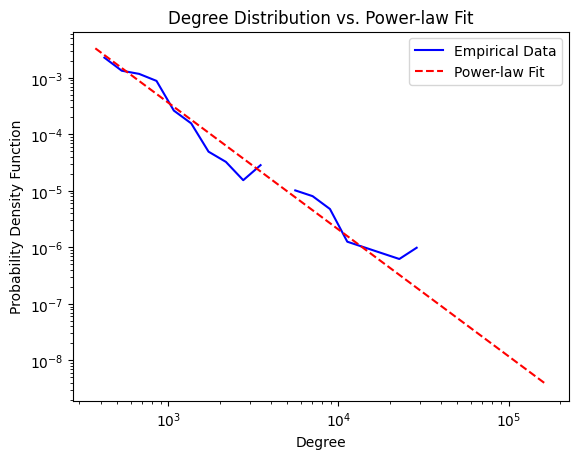

In [ ]:
# 1. Extract degree distribution
degrees = [degree for _, degree in G.degree()]
degree_counts = sorted(degrees, reverse=True)  # Sorted degree counts

# 2. Fit the degree distribution to a power-law model
fit = powerlaw.Fit(degree_counts, discrete=True)

# 3. Print alpha (exponent of the power-law)
print(f"Power-law alpha (scaling exponent): {fit.power_law.alpha}")
print(f"Xmin (cut-off for power-law fit): {fit.power_law.xmin}")

# 4. Perform Kolmogorov-Smirnov test
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Log-likelihood ratio (R): {R}")
print(f"P-value: {p}")

# 5. Visualize the degree distribution and fit
fig = fit.plot_pdf(label='Empirical Data', color='blue')
fit.power_law.plot_pdf(ax=fig, color='red', linestyle='--', label='Power-law Fit')
plt.legend()
plt.title("Degree Distribution vs. Power-law Fit")
plt.xlabel("Degree")
plt.ylabel("Probability Density Function")
plt.show()

This graph illustrates the degree distribution of your network and its alignment with a power-law distribution, offering insights into its structural properties. The scaling exponent (
𝛼
=
2.24
) falls within the typical range observed in many real-world networks (
2
<
𝛼
<
3
), indicating a scale-free structure. This suggests that while a few highly connected nodes (hubs) dominate the network, the distribution of connections remains relatively broad across other nodes.

The power-law behavior is valid above a threshold degree (
𝑋
min
=
372
), meaning that the scale-free pattern is most pronounced for nodes with at least this degree. The distribution aligns well with the power-law fit across a wide range of degrees, including high-degree nodes, reinforcing the presence of hierarchical organization. However, some deviations remain, particularly in the tail of the distribution, suggesting that additional structural mechanisms might be influencing the network.

The log-likelihood ratio (
𝑅
=
2.80
) and the p-value (0.0051) indicate that the power-law model provides a reasonably good fit, but the statistical significance suggests that other models might also explain certain aspects of the degree distribution. This could imply the presence of regional clusters, preferential attachment dynamics, or constraints imposed by historical trade patterns.

In the context of the slave trade network, these findings suggest that key ports, vessels, or individuals acted as dominant hubs, facilitating the major trade routes and shaping the expansion of the network. The fact that the scale-free structure is particularly strong for high-degree nodes reinforces the idea that a small number of critical hubs played a disproportionately large role in maintaining the network's connectivity.

## ***BASIC NETWORK METRICS***

Since we have a **dynamic network** (G) with edges that **vary over time**, we should compute **time-sensitive metrics** by incorporating **decay functions**:

**Summary of Dynamic Metrics**

| **Metric**  | **Purpose** | **Python Function** |
|------------|------------|---------------------|
| **Temporal Centrality** | Tracks **node importance over time** with decay | `compute_temporal_centrality(G, lambda_decay=0.01)` |
| **Dynamic Clustering Coefficient** | Measures how **clusters evolve** over time | `compute_dynamic_clustering(G, time_window=10)` |
| **Temporal Network Density** | Tracks how **dense** the network is at different times | `compute_temporal_density(G, time_window=10)` |
| **Shortest Temporal Paths** | Finds **time-respecting shortest paths** | `compute_temporal_shortest_path(G, source, target)` |
| **Temporal Reachability** | Determines **when** nodes become reachable | `compute_temporal_reachability(G)` |

---

### **🚀 Next Steps**
Would you like to:
1. **Visualize these metrics over time?** 📈
2. **Analyze burstiness and memory effects?** 🔄
3. **Compare your dynamic network to a baseline static version?** ⚖️


#### ***Temporal centrality***<br>
Temporal centrality applies a decay function (*exponential decay*) to discount the importance of old interactions.

In [114]:
# Define historical periods as bins
HISTORICAL_PERIODS = [
    (1514, 1600, "Early Transatlantic Slave Trade"),
    (1601, 1700, "Expansion of European Colonies"),
    (1701, 1800, "Peak of the Transatlantic Slave Trade"),
    (1801, 1830, "Abolitionist Movements Begin"),
    (1831, 1866, "Post-Abolition & Illegal Trade")
]

def assign_period(year):
    """Assigns a given year to a historical period."""
    for start, end, label in HISTORICAL_PERIODS:
        if start <= year <= end:
            return (label, start, end)  # Return label and period range
    return (None, None, None)  # If year is outside known range

def compute_dynamic_clustering(G):
    """
    Compute dynamic clustering coefficient grouped into historical periods.
    """
    # Convert timestamps to years and sort them
    timestamps = sorted(set(
        pendulum.parse(str(d["start_time"])).year
        for _, _, d in G.edges(data=True) if "start_time" in d and d["start_time"]
    ))

    if not timestamps:
        print("No valid timestamps found in the network.")
        return None

    clustering_results = {}  # Store results per historical period

    for label, period_start, period_end in HISTORICAL_PERIODS:
        # Extract edges active within this historical period
        subgraph_edges = [
            (u, v) for u, v, d in G.edges(data=True)
            if "start_time" in d and d["start_time"]
            and period_start <= pendulum.parse(str(d["start_time"])).year <= period_end
        ]

        # Create subgraph for the historical period
        sub_G = G.edge_subgraph(subgraph_edges)

        # Compute clustering coefficient (only if subgraph has edges)
        clustering_results[label] = nx.average_clustering(sub_G) if sub_G.number_of_edges() > 0 else 0

    return clustering_results

# Compute dynamic clustering based on historical periods
dynamic_clustering = compute_dynamic_clustering(G)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Dynamic Clustering per Historical Period", dataframe=dynamic_clustering)

KeyboardInterrupt: 

***Dynamic clustering***

In [ ]:
import pendulum
import numpy as np
import networkx as nx

# Define historical periods as bins
HISTORICAL_PERIODS = [
    (1514, 1600, "Early Transatlantic Slave Trade"),
    (1601, 1700, "Expansion of European Colonies"),
    (1701, 1800, "Peak of the Transatlantic Slave Trade"),
    (1801, 1830, "Abolitionist Movements Begin"),
    (1831, 1866, "Post-Abolition & Illegal Trade")
]

def assign_period(year):
    """Assigns a given year to a historical period."""
    for start, end, label in HISTORICAL_PERIODS:
        if start <= year <= end:
            return (label, end)  # Return the label and the period's end year
    return (None, None)  # If year is outside known range

def compute_temporal_centrality(G, lambda_decay=0.01):
    """
    Compute temporal centrality using exponential decay grouped into historical periods.
    """
    # Extract timestamps (convert to years)
    timestamps = [
        pendulum.parse(str(d["start_time"])).year
        for _, _, d in G.edges(data=True) if "start_time" in d and d["start_time"]
    ]

    if not timestamps:
        print("No timestamps found. Ensure your edges have 'start_time' attributes.")
        return None

    # Find the most recent historical period in the network
    latest_year = max(timestamps)
    _, latest_period_end = assign_period(latest_year)

    if not latest_period_end:
        print("No valid historical periods found in data.")
        return None

    # Compute static centrality (betweenness, but can use degree or closeness)
    centrality_scores = nx.betweenness_centrality(G)

    temporal_centrality = {}
    for node in G.nodes():
        # Find the most recent interaction year for the node
        interactions = [
            pendulum.parse(str(G[u][v]["start_time"])).year
            for u, v in G.edges(node) if "start_time" in G[u][v] and G[u][v]["start_time"]
        ]
        if interactions:
            t = max(interactions)  # Most recent interaction year for the node
            period_label, period_end = assign_period(t)

            if period_label:
                decay_factor = np.exp(-lambda_decay * (latest_period_end - period_end))  # Decay by period end
                temporal_centrality[node] = centrality_scores[node] * decay_factor
            else:
                temporal_centrality[node] = 0  # No valid historical period
        else:
            temporal_centrality[node] = 0  # No interactions

    return temporal_centrality

# Compute temporal centrality using historical periods
temporal_centrality = compute_temporal_centrality(G)

print(temporal_centrality)

***Connectivity and Density***

In [ ]:
#Before check the connectivity
is_connected = nx.is_connected(G)
print(f"Is the graph connected? {is_connected}")
#the graph is not connected, but how much?

density = nx.density(G)
print(f"Network density: {density}")

The ***network density***, which represents the ratio of actual connections in the graph to the total possible connections, is very low (5.0569632475029337e-05), meaning the graph is extremely sparse. In an undirected graph with \( n \) nodes, the maximum number of edges is \( n(n-1)/2 \), but in this network, only a small fraction of those possible connections exist.

This low density is typical for large and complex networks, like this one representing the slave trade, where only specific ports, voyages, or individuals are directly linked. While the density is low, it does not indicate the network is unstructured. Sparse networks often arise in real-world systems, and their analysis should focus on other metrics, such as clustering coefficients, degree distribution, or modularity, to uncover significant patterns and insights.

We now focus on the above mentioned metrics:

***Average path length***

In [ ]:
#since the graph in not connected, we compute the avg path length only for the connected part

#Avg path length -> how close are nodes of a network
#for component in nx.connected_components(G):
#    subgraph = G.subgraph(component)
#    print(f"Average path length in component: {nx.average_shortest_path_length(subgraph)}")

***Degree distribution*** (per node type)

In [ ]:
#Degree distribution -> captures the # of connections of each node in the graph
for node_type in ['arrival_port', 'departure_port', 'purchase_place', 'voyage', 'vessel', 'captain', 'owner']:
    type_degrees = [d for n, d in G.degree() if G.nodes[n].get('type') == node_type]
    print(f"Degree distribution for {node_type}:")
    print(type_degrees)

> To interpret this we can try to plot the degree distribution per node type:

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Adjust grid size if necessary
axes = axes.flatten()  # Convert to 1D list for easy iteration

for idx, node_type in enumerate(['arrival_port', 'departure_port', 'purchase_place', 'voyage', 'vessel', 'captain', 'owner']):
    type_degrees = [d for n, d in G.degree() if G.nodes[n].get('type') == node_type]
    axes[idx].hist(type_degrees, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[idx].set_title(f"Degree Distribution: {node_type.capitalize()}")
    axes[idx].set_xlabel("Degree")
    axes[idx].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

***Clustering coefficient*** (for node type and for all the network)

In [ ]:
from networkx.algorithms import bipartite
print(f"Is the graph bipartite? {nx.is_bipartite(G)}")

In [ ]:
#Clustering coefficient -> how connected node's neighbors are
#computes local clustering coefficient for all and for each node
clustering_coefficients = nx.clustering(G, weight=None)
print(f"Clustering coefficients for the entire network:")
print(clustering_coefficients)

# Display clustering coefficients grouped by node type
for node_type in ['arrival_port', 'departure_port', 'purchase_place', 'voyage', 'vessel', 'captain', 'owner']:
    type_clustering = {n: coeff for n, coeff in clustering_coefficients.items() if G.nodes[n].get('type') == node_type}
    print(f"Clustering coefficients for {node_type}:")
    print(type_clustering)

In [ ]:
# Prepare data for visualization
clustering_coefficients = nx.clustering(G)
node_types = ['arrival_port', 'departure_port', 'purchase_place', 'voyage', 'vessel', 'captain', 'owner']
clustering_data = {}

for node_type in node_types:
    # Extract clustering coefficients for each node type
    clustering_values = [
        coeff for n, coeff in clustering_coefficients.items() if G.nodes[n].get('type') == node_type
    ]
    clustering_data[node_type] = clustering_values

# Plot the clustering coefficients as box plots
plt.figure(figsize=(12, 8))
plt.boxplot(
    [clustering_data[node_type] for node_type in node_types],
    labels=[node_type.capitalize() for node_type in node_types],
    vert=True,
    patch_artist=True,
    showmeans=True
)

# Customize the plot
plt.title("Clustering Coefficients by Node Type", fontsize=16)
plt.xlabel("Node Type", fontsize=14)
plt.ylabel("Clustering Coefficient", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

Based on the provided Python file, project details, and the analysis methods from your course materials, here's a structured approach to your project on analyzing how the slave trade started and expanded, using network science principles:

---

### Outline for the Analysis

#### 1. *Define the Research Question*
   - Central Question: "How did the slave trade start and expand?"
   - Importance: This question explores the structural and dynamic properties of the slave trade network, focusing on key actors (ports, vessels, captains, etc.) and trade patterns over time.
   - Relation to Network Science: The network provides insights into scale-free characteristics, centrality measures, community detection, and robustness.

---

#### 2. *Dataset Preprocessing*
   - Load and clean the dataset (already done in your slave_trade_network.gexf).
   - Ensure node attributes (e.g., type: port, voyage, captain) and edge types (e.g., departed_from, arrived_at) are clear.

---

#### 3. *Network Construction*
   - Construct the undirected network from your dataset (already outlined in your code).
   - Include:
     - Nodes: Ports, voyages, vessels, captains, and owners.
     - Edges: Represent relationships like "departed_from," "commanded_by," etc.
   - Ensure no missing or redundant edges.

---

#### 4. *Basic Network Analysis*
   - Compute key metrics:
     - *Degree Distribution*: Assess scale-free properties by fitting strict and truncated power-law models.
     - *Clustering Coefficients*: Identify local groupings of nodes.
     - *Density*: Measure overall connectivity.
     - *Path Length*: Identify efficiency in the network.
   - Visualize:
     - Degree distribution with fits for strict and truncated power-law models.
     - A subset of the network using layouts like Kamada-Kawai.

---

#### 5. *Identify Hubs and Key Nodes*
   - Use centrality measures:
     - *Degree Centrality*: Identify key ports or vessels with many connections.
     - *Betweenness Centrality*: Locate nodes that control information flow.
     - *Eigenvector Centrality*: Highlight influential actors in the network.
   - Visualize key nodes and their connectivity.

---

#### 6. *Community Detection*
   - Apply clustering methods (e.g., Louvain, Girvan-Newman) to identify communities within the network.
   - Label and analyze communities to understand their roles in the expansion of the trade.

---

#### 7. *Temporal Analysis*
   - If temporal data is available, split the network into time slices (e.g., decades or centuries).
   - Analyze:
     - Changes in the degree distribution.
     - Evolution of community structures.
     - Emergence of hubs.

---

#### 8. *Null Model Comparison*
   - Create random or rewired versions of the network as null models.
   - Compare:
     - Efficiency.
     - Clustering coefficients.
     - Degree distributions.
   - Validate hypotheses about the scale-free or hierarchical nature of the network.

---

#### 9. *Hypothesis Testing*
   - Test if observed metrics (e.g., efficiency, clustering coefficients) differ significantly from the null models.
   - Use statistical tests like paired t-tests or Kolmogorov-Smirnov tests.

---

#### 10. *Dynamic Simulations*
   - Simulate processes like:
     - *Percolation*: Assess network robustness to node/edge removal.
     - *Epidemic Spreading*: Model the spread of trade routes or information.

---

#### 11. *Insights and Presentation*
   - Summarize findings:
     - Key actors (e.g., most influential ports, vessels).
     - Structural insights (e.g., scale-free nature, community roles).
     - Temporal patterns in the trade’s evolution.
   - Use clear visualizations and concise narratives for the presentation.


***use community detection on the existing graph to find groups of vessels that frequently used the same embarkment/disembarkment locations.***